In [ ]:
import numpy as np
import pandas as pd
import os
import tensorflow as tf
from tqdm import tqdm
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import Sequence
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, GlobalAveragePooling2D, Activation, Dropout, Flatten, Dense, Input, Layer
from tensorflow.keras.layers import Embedding, LSTM, add, Concatenate, Reshape, concatenate, Bidirectional
from tensorflow.keras.applications import VGG16, ResNet50, DenseNet201
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import warnings
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

plt.rcParams['font.size'] = 12
sns.set_style("dark")
warnings.filterwarnings('ignore')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#/content/drive/MyDrive/project/flickr8k/Images

In [ ]:
#image_path = '/content/drive/MyDrive/project/flickr8k/Images'
image_path = '/content/drive/MyDrive/Colab Notebooks/msml_612/Project/New_project/flickr8k_kaggle/Images'

In [ ]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/msml_612/Project/New_project/flickr8k_kaggle/captions.txt")
#data = pd.read_csv("/content/drive/MyDrive/project/flickr8k/captions.txt")
data.head()

image  \
0  1000268201_693b08cb0e.jpg   
1  1000268201_693b08cb0e.jpg   
2  1000268201_693b08cb0e.jpg   
3  1000268201_693b08cb0e.jpg   
4  1000268201_693b08cb0e.jpg   

                                             caption  
0  A child in a pink dress is climbing up a set o...  
1              A girl going into a wooden building .  
2   A little girl climbing into a wooden playhouse .  
3  A little girl climbing the stairs to her playh...  
4  A little girl in a pink dress going into a woo...

In [ ]:
def readImage(path,img_size=224):
    img = load_img(path,color_mode='rgb',target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.

    return img

def display_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"/content/drive/MyDrive/Colab Notebooks/msml_612/Project/New_project/flickr8k_kaggle/Images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")

Visulization


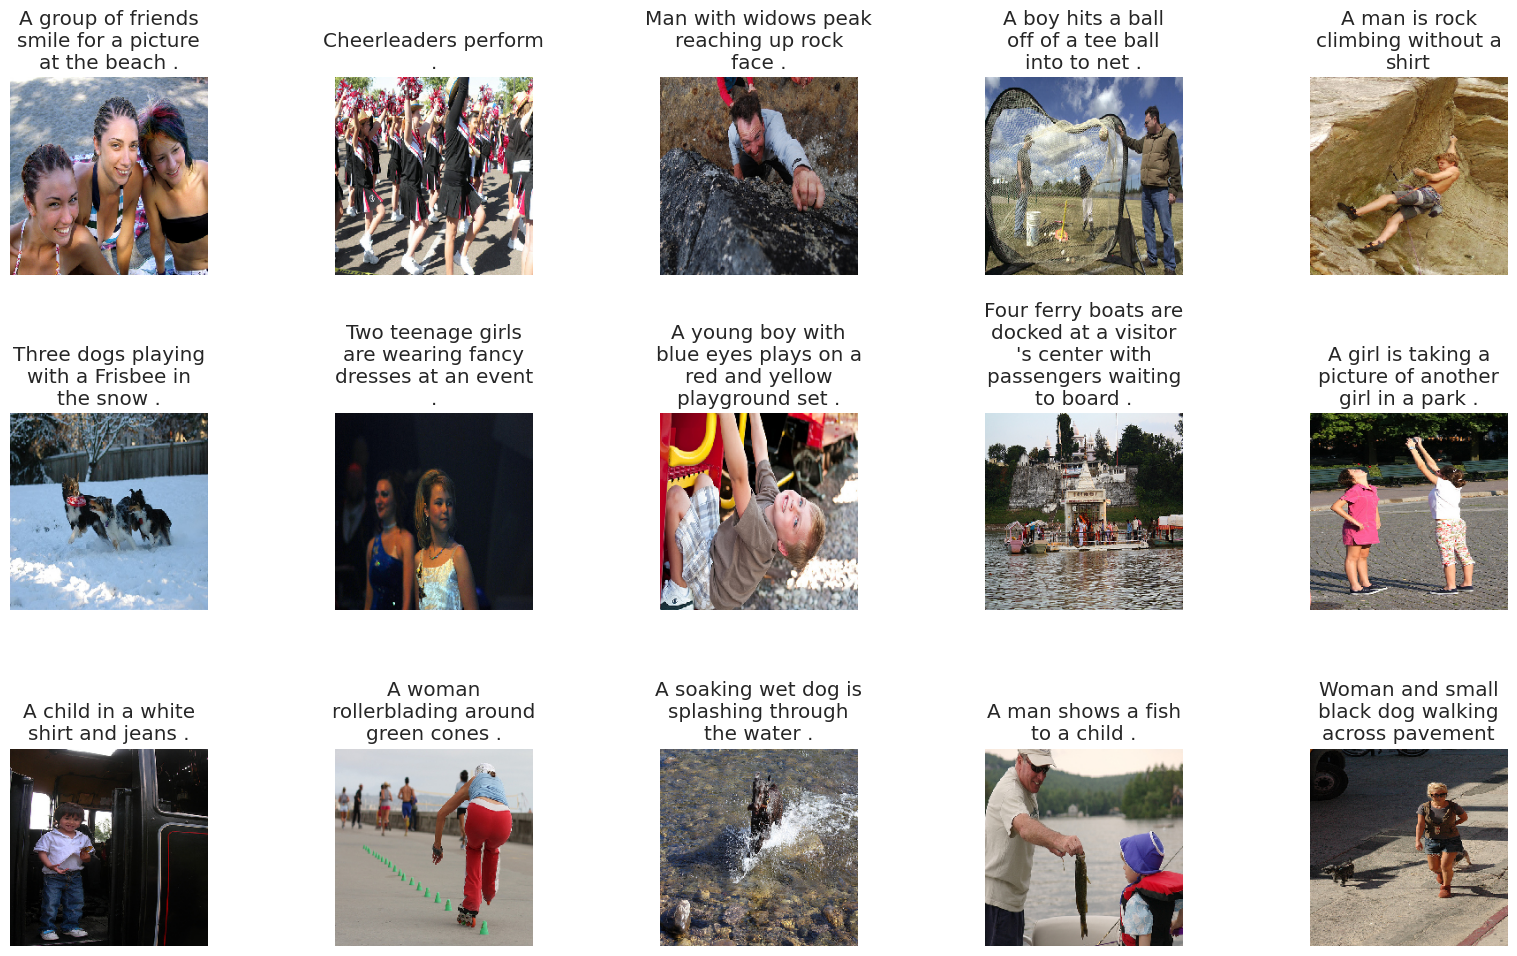

In [ ]:
display_images(data.sample(15))

Caption Text Preprocessing Steps

1.   Convert sentences into lowercase

2.   Remove special characters and numbers present in the text

3.   Remove extra spaces

4.   Remove single characters

5.   Add a starting and an ending tag to the sentences to indicate the beginning and the ending of a sentence

In [ ]:
def text_preprocessing(data):
    data['caption'] = data['caption'].apply(lambda x: x.lower())
    data['caption'] = data['caption'].apply(lambda x: x.replace("[^A-Za-z]",""))
    data['caption'] = data['caption'].apply(lambda x: x.replace("\s+"," "))
    data['caption'] = data['caption'].apply(lambda x: " ".join([word for word in x.split() if len(word)>1]))
    data['caption'] = "startseq "+data['caption']+" endseq"
    return data

Preprocessed Text

In [ ]:
data = text_preprocessing(data)
captions = data['caption'].tolist()
captions[:10]

['startseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'startseq girl going into wooden building endseq',
 'startseq little girl climbing into wooden playhouse endseq',
 'startseq little girl climbing the stairs to her playhouse endseq',
 'startseq little girl in pink dress going into wooden cabin endseq',
 'startseq black dog and spotted dog are fighting endseq',
 'startseq black dog and tri-colored dog playing with each other on the road endseq',
 'startseq black dog and white dog with brown spots are staring at each other in the street endseq',
 'startseq two dogs of different breeds looking at each other on the road endseq',
 'startseq two dogs on pavement moving toward each other endseq']

### Tokenization and Encoded Representation



In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(captions)
vocab_size = len(tokenizer.word_index) + 1
max_length = max(len(caption.split()) for caption in captions)

images = data['image'].unique().tolist()
nimages = len(images)

split_index = round(0.85*nimages)
train_images = images[:split_index]
val_images = images[split_index:]

train = data[data['image'].isin(train_images)]
test = data[data['image'].isin(val_images)]

train.reset_index(inplace=True,drop=True)
test.reset_index(inplace=True,drop=True)

tokenizer.texts_to_sequences([captions[1]])[0]

[1, 18, 315, 63, 195, 116, 2]

### Image Feature Extraction

1.  DenseNet 201 Architecture is used to extract the features from the images

2.   Since the Global Average Pooling layer is selected as the final layer of the DenseNet201 model for our feature extraction, our image embeddings will be a vector of size 1920



In [ ]:
model = DenseNet201()
fe = Model(inputs=model.input, outputs=model.layers[-2].output)
fe.summary()
img_size = 224
features = {}

82524592/82524592 [==============================] - 5s 0us/step
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 zero_padding2d (ZeroPadding2D)  (None, 230, 230, 3)  0          ['input_1[0][0]']                
                                                                                                  
 conv1/conv (Conv2D)            (None, 112, 112, 64  9408        ['zero_padding2d[0][0]']         
                                )                                                                 
                             

In [ ]:

for image in tqdm(data['image'].unique().tolist()):
    img = load_img(os.path.join(image_path,image),target_size=(img_size,img_size))
    img = img_to_array(img)
    img = img/255.
    img = np.expand_dims(img,axis=0)
    feature = fe.predict(img, verbose=0)
    features[image] = feature

82524592/82524592 [==============================] - 1s 0us/step


100%|██████████| 8091/8091 [30:27<00:00,  4.43it/s]


In [ ]:
import pickle
with open('/content/drive/MyDrive/Colab Notebooks/msml_612/Project/New_project/Densenet_201_cnn+lstm/Densenet_201_cnn_lstms_feature_data.pkl', 'wb') as fp:
    pickle.dump(features, fp)
    print('dictionary saved successfully to file')

dictionary saved successfully to file


In [ ]:
"""import pickle
with open('/content/drive/MyDrive/Colab Notebooks/msml_612/Project/New_project/Densenet_201_cnn+lstm/Densenet_201_cnn_lstms_feature_data.pkl', 'rb') as fp:
  features = pickle.load(fp)"""

"import pickle\nwith open('/content/drive/MyDrive/Colab Notebooks/msml_612/Project/New_project/Densenet_201_cnn_lstms_feature_data.pkl', 'rb') as fp:\n  features = pickle.load(fp)"

### Data Generation




In [ ]:
class CustomDataGenerator(Sequence):

    def __init__(self, df, X_col, y_col, batch_size, directory, tokenizer,
                 vocab_size, max_length, features,shuffle=True):

        self.df = df.copy()
        self.X_col = X_col
        self.y_col = y_col
        self.directory = directory
        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.vocab_size = vocab_size
        self.max_length = max_length
        self.features = features
        self.shuffle = shuffle
        self.n = len(self.df)

    def on_epoch_end(self):
        if self.shuffle:
            self.df = self.df.sample(frac=1).reset_index(drop=True)

    def __len__(self):
        return self.n // self.batch_size

    def __getitem__(self,index):

        batch = self.df.iloc[index * self.batch_size:(index + 1) * self.batch_size,:]
        X1, X2, y = self.__get_data(batch)
        return (X1, X2), y

    def __get_data(self,batch):

        X1, X2, y = list(), list(), list()

        images = batch[self.X_col].tolist()

        for image in images:
            feature = self.features[image][0]

            captions = batch.loc[batch[self.X_col]==image, self.y_col].tolist()
            for caption in captions:
                seq = self.tokenizer.texts_to_sequences([caption])[0]

                for i in range(1,len(seq)):
                    in_seq, out_seq = seq[:i], seq[i]
                    in_seq = pad_sequences([in_seq], maxlen=self.max_length)[0]
                    out_seq = to_categorical([out_seq], num_classes=self.vocab_size)[0]
                    X1.append(feature)
                    X2.append(in_seq)
                    y.append(out_seq)

        X1, X2, y = np.array(X1), np.array(X2), np.array(y)

        return X1, X2, y

### Modelling




In [ ]:
input1 = Input(shape=(1920,))
input2 = Input(shape=(max_length,))

img_features = Dense(256, activation='relu')(input1)
img_features_reshaped = Reshape((1, 256), input_shape=(256,))(img_features)

sentence_features = Embedding(vocab_size, 256, mask_zero=False)(input2)
merged = concatenate([img_features_reshaped,sentence_features],axis=1)
sentence_features = LSTM(256)(merged)
x = Dropout(0.5)(sentence_features)
x = add([x, img_features])
x = Dense(128, activation='relu')(x)
x = Dropout(0.5)(x)
output = Dense(vocab_size, activation='softmax')(x)

caption_model = Model(inputs=[input1,input2], outputs=output)
caption_model.compile(loss='categorical_crossentropy',optimizer='adam')

In [ ]:
from tensorflow.keras.utils import plot_model

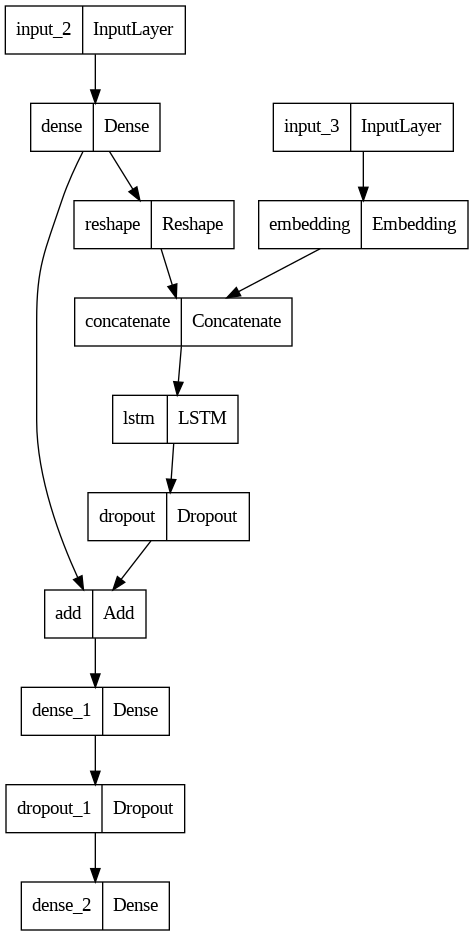

In [ ]:
plot_model(caption_model)

In [ ]:
caption_model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 1920)]       0           []                               
                                                                                                  
 dense (Dense)                  (None, 256)          491776      ['input_2[0][0]']                
                                                                                                  
 input_3 (InputLayer)           [(None, 34)]         0           []                               
                                                                                                  
 reshape (Reshape)              (None, 1, 256)       0           ['dense[0][0]']                  
                                                                                            

In [ ]:
train_generator = CustomDataGenerator(df=train,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

validation_generator = CustomDataGenerator(df=test,X_col='image',y_col='caption',batch_size=64,directory=image_path,
                                      tokenizer=tokenizer,vocab_size=vocab_size,max_length=max_length,features=features)

In [ ]:
model_name = "model.h5"
checkpoint = ModelCheckpoint(model_name,
                            monitor="val_loss",
                            mode="min",
                            save_best_only = True,
                            verbose=1)

earlystopping = EarlyStopping(monitor='val_loss',min_delta = 0, patience = 5, verbose = 1, restore_best_weights=True)

learning_rate_reduction = ReduceLROnPlateau(monitor='val_loss',
                                            patience=3,
                                            verbose=1,
                                            factor=0.2,
                                            min_lr=0.00000001)

In [ ]:
history = caption_model.fit(train_generator,epochs=50,validation_data=validation_generator,callbacks=[checkpoint,earlystopping,learning_rate_reduction])

Epoch 1/50
537/537 [==============================] - ETA: 0s - loss: 5.1207
Epoch 1: val_loss improved from inf to 4.23033, saving model to model.h5
537/537 [==============================] - 188s 341ms/step - loss: 5.1207 - val_loss: 4.2303 - lr: 0.0010
Epoch 2/50
537/537 [==============================] - ETA: 0s - loss: 4.1630
Epoch 2: val_loss improved from 4.23033 to 3.89557, saving model to model.h5
537/537 [==============================] - 48s 90ms/step - loss: 4.1630 - val_loss: 3.8956 - lr: 0.0010
Epoch 3/50
537/537 [==============================] - ETA: 0s - loss: 3.8948
Epoch 3: val_loss improved from 3.89557 to 3.75387, saving model to model.h5
537/537 [==============================] - 40s 75ms/step - loss: 3.8948 - val_loss: 3.7539 - lr: 0.0010
Epoch 4/50
537/537 [==============================] - ETA: 0s - loss: 3.7334
Epoch 4: val_loss improved from 3.75387 to 3.67543, saving model to model.h5
537/537 [==============================] - 40s 73ms/step - loss: 3.7334 - 

In [ ]:
caption_model.save('/content/drive/MyDrive/Colab Notebooks/msml_612/Project/New_project/Densenet_201_cnn+lstm/CNNS+LSTMS_model.h5') # save model

## Caption Generation Utility Functions



1.   Utility functions to generate the captions of input images at the inference time.
2.   Here the image embeddings are passed along with the first word, followed by which the text embedding of each new word is passed to generate the next word




In [ ]:
def idx_to_word(integer,tokenizer):

    for word, index in tokenizer.word_index.items():
        if index==integer:
            return word
    return None

In [ ]:
def predict_caption(model, image, tokenizer, max_length, features):

    feature = features[image]
    in_text = "startseq"
    for i in range(max_length):
        sequence = tokenizer.texts_to_sequences([in_text])[0]
        sequence = pad_sequences([sequence], max_length)

        y_pred = model.predict([feature,sequence])
        y_pred = np.argmax(y_pred)

        word = idx_to_word(y_pred, tokenizer)

        if word is None:
            break

        in_text+= " " + word

        if word == 'endseq':
            break

    return in_text

Taking 15 Random Samples for Caption Prediction


In [ ]:
samples = test.sample(15)
samples.reset_index(drop=True,inplace=True)

In [ ]:
for index,record in samples.iterrows():

    img = load_img(os.path.join(image_path,record['image']),target_size=(224,224))
    img = img_to_array(img)
    img = img/255.

    caption = predict_caption(caption_model, record['image'], tokenizer, max_length, features)
    #print(caption)
    samples.loc[index,'new_caption'] = caption

1/1 [==============================] - 0s 21ms/step


## Results





In [ ]:
def display_generated_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (20 , 20))
    n = 0
    for i in range(15):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"/content/drive/MyDrive/Colab Notebooks/msml_612/Project/New_project/flickr8k_kaggle/Images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.new_caption[i], 20)))
        plt.axis("off")

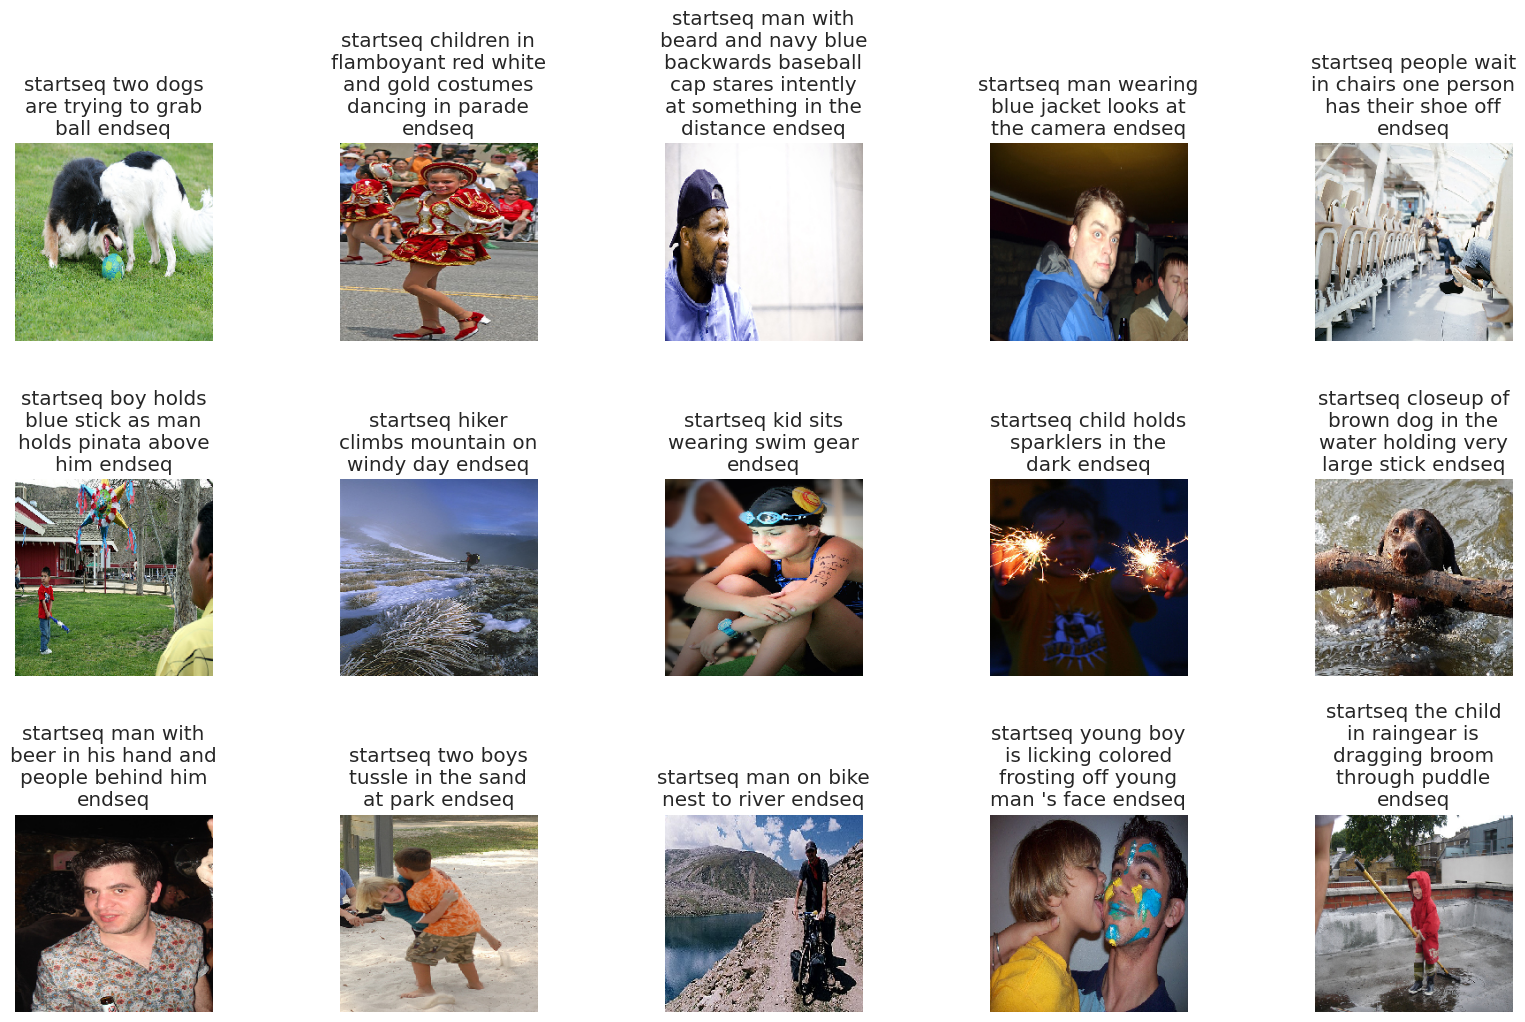

In [ ]:
display_images(samples)

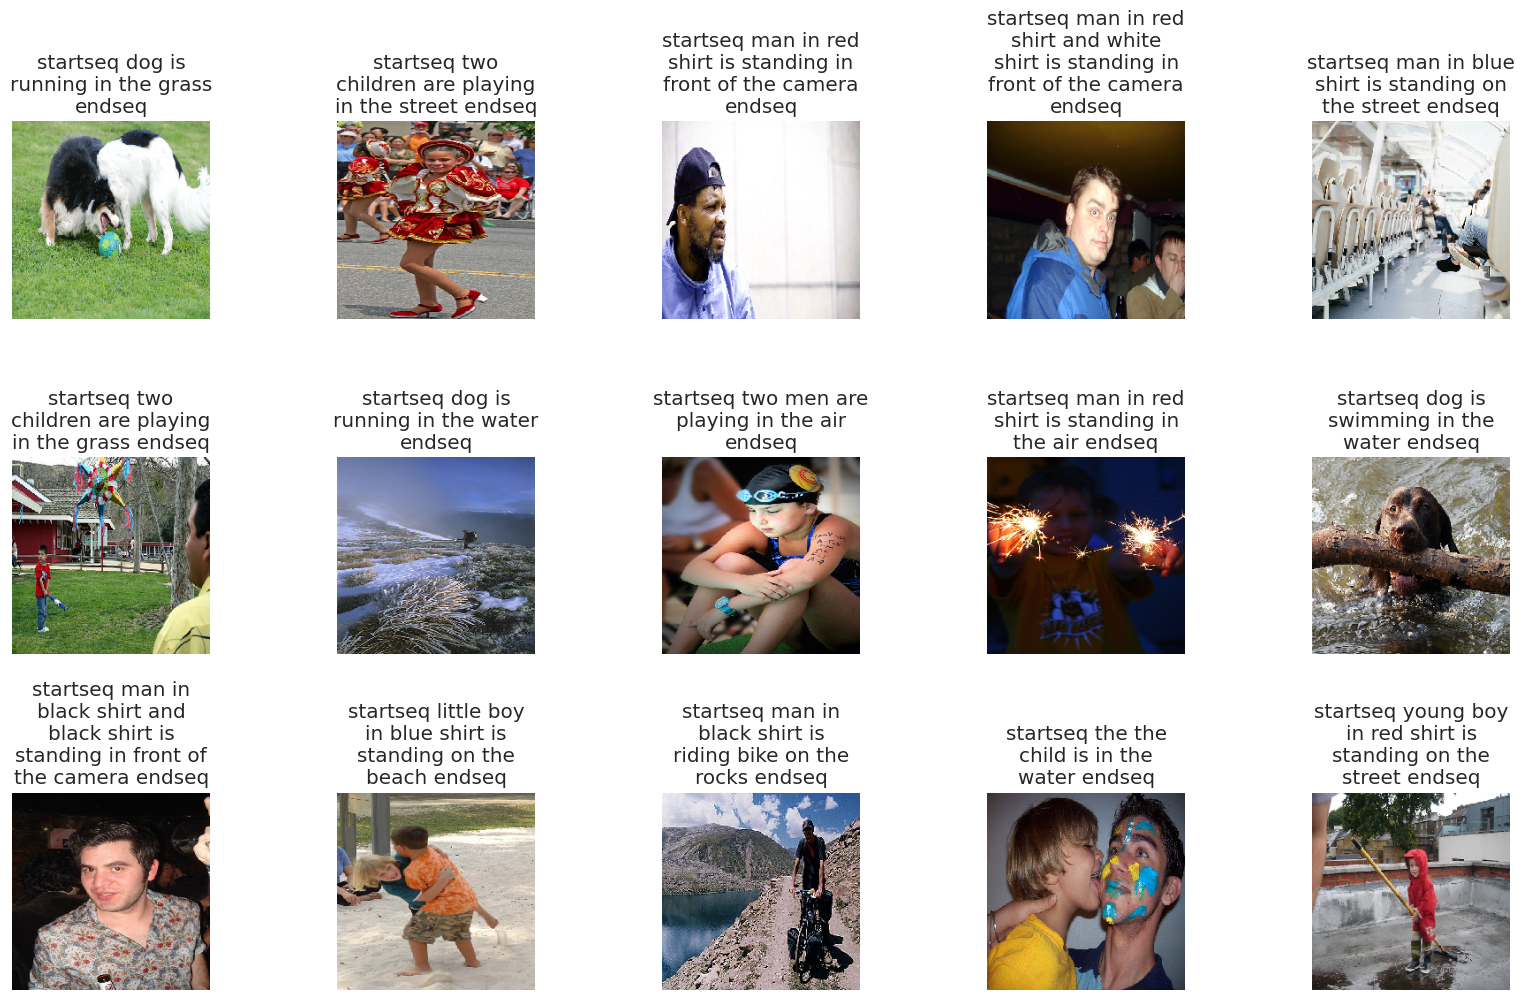

In [ ]:
display_generated_images(samples)

In [ ]:
samples

image  \
0    496380034_d22aeeedb3.jpg   
1   3733074526_82aa8d5f8d.jpg   
2    802594049_289e3c8420.jpg   
3    397286183_745abbf40d.jpg   
4    469617651_278e586e46.jpg   
5    412082368_371df946b3.jpg   
6    390992102_67fa31b22f.jpg   
7    652542470_60e858da64.jpg   
8    747921928_48eb02aab2.jpg   
9    468930779_8008d90e10.jpg   
10   374104006_7f32c8c5de.jpg   
11   525538142_7348f0bce7.jpg   
12    95734038_2ab5783da7.jpg   
13   957230475_48f4285ffe.jpg   
14   693164706_9624582e69.jpg   

                                              caption  \
0    startseq two dogs are trying to grab ball endseq   
1   startseq children in flamboyant red white and ...   
2   startseq man with beard and navy blue backward...   
3   startseq man wearing blue jacket looks at the ...   
4   startseq people wait in chairs one person has ...   
5   startseq boy holds blue stick as man holds pin...   
6   startseq hiker climbs mountain on windy day en...   
7          startseq kid sits wearing swim gear endseq   
8   startseq child holds sparklers in the dark endseq   
9   startseq closeup of brown dog in the water hol...   
10  startseq man with beer in his hand and people ...   
11  startseq two boys tussle in the sand at park e...   
12          startseq man on bike nest to river endseq   
13  startseq young boy is licking colored frosting...   
14  startseq the child in raingear is dragging bro...   

                                          new_caption  
0         startseq dog is running in the grass endseq  
1   startseq two children are playing in the stree...  
2   startseq man in red shirt is standing in front...  
3   startseq man in red shirt and white shirt is s...  
4   startseq man in blue shirt is standing on the ...  
5   startseq two children are playing in the grass...  
6         startseq dog is running in the water endseq  
7      startseq two men are playing in the air endseq  
8   startseq man in red shirt is standing in the a...  
9        startseq dog is swimming in the water endseq  
10  startseq man in black shirt and black shirt is...  
11  startseq little boy in blue shirt is standing ...  
12  startseq man in black shirt is riding bike on ...  
13      startseq the the child is in the water endseq  
14  startseq young boy in red shirt is standing on...

### Test on test set

In [ ]:
Test_set = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/msml_612/Project/New_project/15_percent_test_set.csv")
Test_set

Unnamed: 0                      image  \
0              0  3688858505_e8afd1475d.jpg   
1              1  3688858505_e8afd1475d.jpg   
2              2  3688858505_e8afd1475d.jpg   
3              3  3688858505_e8afd1475d.jpg   
4              4  3688858505_e8afd1475d.jpg   
...          ...                        ...   
6065        6065   997722733_0cb5439472.jpg   
6066        6066   997722733_0cb5439472.jpg   
6067        6067   997722733_0cb5439472.jpg   
6068        6068   997722733_0cb5439472.jpg   
6069        6069   997722733_0cb5439472.jpg   

                                                caption  
0     startseq blond girl in green dress and elabora...  
1     startseq few people with girl standing up in t...  
2              startseq girl is wear green dress endseq  
3     startseq blonde girl wearing green dress stand...  
4     startseq woman in green dress being observed e...  
...                                                 ...  
6065  startseq man in pink shirt climbs rock face en...  
6066  startseq man is rock climbing high in the air ...  
6067  startseq person in red shirt climbing up rock ...  
6068          startseq rock climber in red shirt endseq  
6069  startseq rock climber practices on rock climbi...  

[6070 rows x 3 columns]

In [ ]:
test_dataset = pd.DataFrame()
for index,record in Test_set.iterrows():
  if index%5 == 0:
    #df2 = pd.concat([new_row,df.loc[:]]).reset_index(drop=True)
    test_dataset = test_dataset.append(record,ignore_index=True)
test_dataset.reset_index(drop=True,inplace=True)
test_dataset

Unnamed: 0                      image  \
0              0  3688858505_e8afd1475d.jpg   
1              5  3689355450_fd559b816d.jpg   
2             10   368954110_821ccf005c.jpg   
3             15  3689727848_b53f931130.jpg   
4             20  3689975998_72f50b6d91.jpg   
...          ...                        ...   
1209        6045   990890291_afc72be141.jpg   
1210        6050    99171998_7cc800ceef.jpg   
1211        6055    99679241_adc853a5c0.jpg   
1212        6060   997338199_7343367d7f.jpg   
1213        6065   997722733_0cb5439472.jpg   

                                                caption  
0     startseq blond girl in green dress and elabora...  
1     startseq boy wearing plaid shorts jumping over...  
2     startseq girl in purple top holds toddler betw...  
3     startseq boy tries to catch ball while jumping...  
4      startseq an asian girl is running outside endseq  
...                                                 ...  
1209  startseq man does wheelie on his bicycle on th...  
1210  startseq group is sitting around snowy crevass...  
1211  startseq grey bird stands majestically on beac...  
1212    startseq person stands near golden walls endseq  
1213  startseq man in pink shirt climbs rock face en...  

[1214 rows x 3 columns]

In [ ]:
for index,record in test_dataset.iterrows():

    img = load_img(os.path.join(image_path,record['image']),target_size=(224,224))
    img = img_to_array(img)
    img = img/255.

    caption = predict_caption(caption_model, record['image'], tokenizer, max_length, features)
    #print(caption)
    test_dataset.loc[index,'new_caption'] = caption

流式输出内容被截断，只能显示最后 5000 行内容。
1/1 [==============================] - 0s 21ms/step


In [ ]:
test_dataset

Unnamed: 0                      image  \
0              0  3688858505_e8afd1475d.jpg   
1              5  3689355450_fd559b816d.jpg   
2             10   368954110_821ccf005c.jpg   
3             15  3689727848_b53f931130.jpg   
4             20  3689975998_72f50b6d91.jpg   
...          ...                        ...   
1209        6045   990890291_afc72be141.jpg   
1210        6050    99171998_7cc800ceef.jpg   
1211        6055    99679241_adc853a5c0.jpg   
1212        6060   997338199_7343367d7f.jpg   
1213        6065   997722733_0cb5439472.jpg   

                                                caption  \
0     startseq blond girl in green dress and elabora...   
1     startseq boy wearing plaid shorts jumping over...   
2     startseq girl in purple top holds toddler betw...   
3     startseq boy tries to catch ball while jumping...   
4      startseq an asian girl is running outside endseq   
...                                                 ...   
1209  startseq man does wheelie on his bicycle on th...   
1210  startseq group is sitting around snowy crevass...   
1211  startseq grey bird stands majestically on beac...   
1212    startseq person stands near golden walls endseq   
1213  startseq man in pink shirt climbs rock face en...   

                                            new_caption  
0     startseq two women are standing on the street ...  
1     startseq man in red shirt is jumping off of th...  
2     startseq two women are standing in the grass e...  
3     startseq man in blue shirt is in the water endseq  
4     startseq man in red shirt is standing on the g...  
...                                                 ...  
1209  startseq man in red shirt is riding bicycle on...  
1210  startseq two people are standing on the snow e...  
1211  startseq the white bird is flying in the water...  
1212  startseq man in red shirt and black and white ...  
1213  startseq man in red shirt is climbing rock endseq  

[1214 rows x 4 columns]

In [ ]:
# zoom out
for index,record in test_dataset.iterrows():
  for i in range(0,5):
    Test_set.loc[index*5+i,"new_caption"] = record["new_caption"]

Test_set

Unnamed: 0                      image  \
0              0  3688858505_e8afd1475d.jpg   
1              1  3688858505_e8afd1475d.jpg   
2              2  3688858505_e8afd1475d.jpg   
3              3  3688858505_e8afd1475d.jpg   
4              4  3688858505_e8afd1475d.jpg   
...          ...                        ...   
6065        6065   997722733_0cb5439472.jpg   
6066        6066   997722733_0cb5439472.jpg   
6067        6067   997722733_0cb5439472.jpg   
6068        6068   997722733_0cb5439472.jpg   
6069        6069   997722733_0cb5439472.jpg   

                                                caption  \
0     startseq blond girl in green dress and elabora...   
1     startseq few people with girl standing up in t...   
2              startseq girl is wear green dress endseq   
3     startseq blonde girl wearing green dress stand...   
4     startseq woman in green dress being observed e...   
...                                                 ...   
6065  startseq man in pink shirt climbs rock face en...   
6066  startseq man is rock climbing high in the air ...   
6067  startseq person in red shirt climbing up rock ...   
6068          startseq rock climber in red shirt endseq   
6069  startseq rock climber practices on rock climbi...   

                                            new_caption  
0     startseq two women are standing on the street ...  
1     startseq two women are standing on the street ...  
2     startseq two women are standing on the street ...  
3     startseq two women are standing on the street ...  
4     startseq two women are standing on the street ...  
...                                                 ...  
6065  startseq man in red shirt is climbing rock endseq  
6066  startseq man in red shirt is climbing rock endseq  
6067  startseq man in red shirt is climbing rock endseq  
6068  startseq man in red shirt is climbing rock endseq  
6069  startseq man in red shirt is climbing rock endseq  

[6070 rows x 4 columns]

### Evaluaions

In [ ]:
#Test_set = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/msml_612/Project/New_project/Densenet_201_cnn+lstm/Test_set_sim.csv")

In [ ]:
Test_set

Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0                      image  \
0                0             0           0  3688858505_e8afd1475d.jpg   
1                1             1           1  3688858505_e8afd1475d.jpg   
2                2             2           2  3688858505_e8afd1475d.jpg   
3                3             3           3  3688858505_e8afd1475d.jpg   
4                4             4           4  3688858505_e8afd1475d.jpg   
...            ...           ...         ...                        ...   
6065          6065          6065        6065   997722733_0cb5439472.jpg   
6066          6066          6066        6066   997722733_0cb5439472.jpg   
6067          6067          6067        6067   997722733_0cb5439472.jpg   
6068          6068          6068        6068   997722733_0cb5439472.jpg   
6069          6069          6069        6069   997722733_0cb5439472.jpg   

                                                caption  \
0     startseq blond girl in green dress and elabora...   
1     startseq few people with girl standing up in t...   
2              startseq girl is wear green dress endseq   
3     startseq blonde girl wearing green dress stand...   
4     startseq woman in green dress being observed e...   
...                                                 ...   
6065  startseq man in pink shirt climbs rock face en...   
6066  startseq man is rock climbing high in the air ...   
6067  startseq person in red shirt climbing up rock ...   
6068          startseq rock climber in red shirt endseq   
6069  startseq rock climber practices on rock climbi...   

                                            new_caption  sim_score  
0     startseq two women are standing on the street ...     0.4324  
1     startseq two women are standing on the street ...     0.5843  
2     startseq two women are standing on the street ...     0.4402  
3     startseq two women are standing on the street ...     0.5515  
4     startseq two women are standing on the street ...     0.5339  
...                                                 ...        ...  
6065  startseq man in red shirt is climbing rock endseq     0.8754  
6066  startseq man in red shirt is climbing rock endseq     0.8482  
6067  startseq man in red shirt is climbing rock endseq     0.8879  
6068  startseq man in red shirt is climbing rock endseq     0.8923  
6069  startseq man in red shirt is climbing rock endseq     0.6882  

[6070 rows x 7 columns]

In [ ]:
Test_set['caption'] = Test_set['caption'].str.replace('startseq', '')
Test_set['caption'] = Test_set['caption'].str.replace('endseq', '')
Test_set['caption'] = Test_set['caption'].str.strip()

Test_set['new_caption'] = Test_set['new_caption'].str.replace('startseq', '')
Test_set['new_caption'] = Test_set['new_caption'].str.replace('endseq', '')
Test_set['new_caption'] = Test_set['new_caption'].str.strip()
Test_set = Test_set.drop(columns=['sim_score'])
Test_set

Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0                      image  \
0                0             0           0  3688858505_e8afd1475d.jpg   
1                1             1           1  3688858505_e8afd1475d.jpg   
2                2             2           2  3688858505_e8afd1475d.jpg   
3                3             3           3  3688858505_e8afd1475d.jpg   
4                4             4           4  3688858505_e8afd1475d.jpg   
...            ...           ...         ...                        ...   
6065          6065          6065        6065   997722733_0cb5439472.jpg   
6066          6066          6066        6066   997722733_0cb5439472.jpg   
6067          6067          6067        6067   997722733_0cb5439472.jpg   
6068          6068          6068        6068   997722733_0cb5439472.jpg   
6069          6069          6069        6069   997722733_0cb5439472.jpg   

                                                caption  \
0     blond girl in green dress and elaborate gold n...   
1     few people with girl standing up in the center...   
2                              girl is wear green dress   
3              blonde girl wearing green dress standing   
4                   woman in green dress being observed   
...                                                 ...   
6065                 man in pink shirt climbs rock face   
6066               man is rock climbing high in the air   
6067  person in red shirt climbing up rock face cove...   
6068                          rock climber in red shirt   
6069       rock climber practices on rock climbing wall   

                               new_caption  
0     two women are standing on the street  
1     two women are standing on the street  
2     two women are standing on the street  
3     two women are standing on the street  
4     two women are standing on the street  
...                                    ...  
6065     man in red shirt is climbing rock  
6066     man in red shirt is climbing rock  
6067     man in red shirt is climbing rock  
6068     man in red shirt is climbing rock  
6069     man in red shirt is climbing rock  

[6070 rows x 6 columns]

In [ ]:
!pip install -U sentence-transformers

In [ ]:
from sentence_transformers import SentenceTransformer, util
lan_model = SentenceTransformer('distilbert-base-nli-mean-tokens')

In [ ]:
for index,record in Test_set.iterrows():
  sentences = []
  sentences.append(record["caption"])
  sentences.append(record["new_caption"])
  #print(sentences)
  embeddings = lan_model.encode(sentences)
  sim = util.cos_sim(embeddings[0], embeddings[1])
  Test_set.loc[index,'sim_score'] = round(sim.tolist()[0][0],4)
Test_set

Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0                      image  \
0                0             0           0  3688858505_e8afd1475d.jpg   
1                1             1           1  3688858505_e8afd1475d.jpg   
2                2             2           2  3688858505_e8afd1475d.jpg   
3                3             3           3  3688858505_e8afd1475d.jpg   
4                4             4           4  3688858505_e8afd1475d.jpg   
...            ...           ...         ...                        ...   
6065          6065          6065        6065   997722733_0cb5439472.jpg   
6066          6066          6066        6066   997722733_0cb5439472.jpg   
6067          6067          6067        6067   997722733_0cb5439472.jpg   
6068          6068          6068        6068   997722733_0cb5439472.jpg   
6069          6069          6069        6069   997722733_0cb5439472.jpg   

                                                caption  \
0     blond girl in green dress and elaborate gold n...   
1     few people with girl standing up in the center...   
2                              girl is wear green dress   
3              blonde girl wearing green dress standing   
4                   woman in green dress being observed   
...                                                 ...   
6065                 man in pink shirt climbs rock face   
6066               man is rock climbing high in the air   
6067  person in red shirt climbing up rock face cove...   
6068                          rock climber in red shirt   
6069       rock climber practices on rock climbing wall   

                               new_caption  sim_score  
0     two women are standing on the street     0.4167  
1     two women are standing on the street     0.5781  
2     two women are standing on the street     0.4094  
3     two women are standing on the street     0.5245  
4     two women are standing on the street     0.4649  
...                                    ...        ...  
6065     man in red shirt is climbing rock     0.8894  
6066     man in red shirt is climbing rock     0.8448  
6067     man in red shirt is climbing rock     0.8901  
6068     man in red shirt is climbing rock     0.8922  
6069     man in red shirt is climbing rock     0.6798  

[6070 rows x 7 columns]

In [ ]:
Test_set.to_csv("/content/drive/MyDrive/Colab Notebooks/msml_612/Project/New_project/Densenet_201_cnn+lstm/Test_set_sim.csv")

### Average similarity score

In [ ]:
count_row = Test_set.shape[0]
total_sim = 0
for index,record in Test_set.iterrows():
  total_sim+=record["sim_score"]
average_score = round((total_sim/count_row), 4)
print("the average similarity socre for test set using DensetNet as encoder is " + str(average_score))

the average similarity socre for test set using DensetNet as encoder is 0.5302


### Bleu

In [ ]:
import pandas as pd
Test_set = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/msml_612/Project/New_project/Densenet_201_cnn+lstm/Test_set_sim.csv")

In [ ]:
import re

column_name = 'caption'

# Create a new DataFrame to store the results
result_data = []

# Iterate through the DataFrame using iterrows
chunk_size = 5
for index, row in Test_set.iterrows():
    if index % chunk_size == 0:
        start_index = index
        end_index = min(index + chunk_size, len(Test_set))
        #chunk = Test_set.loc[start_index:end_index - 1, column_name]
        #combined_vocabs = ' '.join(set(re.findall(r'\b\w+\b', ' '.join(chunk))))
        Fir_caption = Test_set.loc[start_index, column_name]
        sec_caption = Test_set.loc[start_index+1, column_name]
        thr_caption = Test_set.loc[start_index+2, column_name]
        fou_caption = Test_set.loc[start_index+3, column_name]
        fif_caption = Test_set.loc[start_index+4, column_name]
        #result_data.append({'image': Test_set.loc[start_index,"image"], 'Combined_Vocabs': combined_vocabs,'new_caption':Test_set.loc[start_index,"new_caption"]})
        result_data.append({'image': Test_set.loc[start_index,"image"], 'First_caption': Fir_caption, 'Second_caption': sec_caption,
                            'Thrid_caption': thr_caption,'Forth_caption': fou_caption,'Fifth_caption': fif_caption, 'new_caption':Test_set.loc[start_index,"new_caption"]})
# Create the result DataFrame
result_df = pd.DataFrame(result_data)

In [ ]:
result_df

image  \
0     3688858505_e8afd1475d.jpg   
1     3689355450_fd559b816d.jpg   
2      368954110_821ccf005c.jpg   
3     3689727848_b53f931130.jpg   
4     3689975998_72f50b6d91.jpg   
...                         ...   
1209   990890291_afc72be141.jpg   
1210    99171998_7cc800ceef.jpg   
1211    99679241_adc853a5c0.jpg   
1212   997338199_7343367d7f.jpg   
1213   997722733_0cb5439472.jpg   

                                          First_caption  \
0     blond girl in green dress and elaborate gold n...   
1     boy wearing plaid shorts jumping over big wate...   
2     girl in purple top holds toddler between herse...   
3       boy tries to catch ball while jumping into pool   
4                      an asian girl is running outside   
...                                                 ...   
1209    man does wheelie on his bicycle on the sidewalk   
1210             group is sitting around snowy crevasse   
1211  grey bird stands majestically on beach while w...   
1212                    person stands near golden walls   
1213                 man in pink shirt climbs rock face   

                                         Second_caption  \
0     few people with girl standing up in the center...   
1          man in plaid shorts is jumping over fountain   
2                       three children sit on the grass   
3          male dives for ball that 's flying over pool   
4               an asian woman is running on rocky path   
...                                                 ...   
1209              man is doing wheelie on mountain bike   
1210            group of people sit atop snowy mountain   
1211        large bird stands in the water on the beach   
1212              woman behind scrolled wall is writing   
1213               man is rock climbing high in the air   

                                          Thrid_caption  \
0                              girl is wear green dress   
1                    man is jumping over water fountain   
2        three little children are sitting in the grass   
3                       male jumping into swimming pool   
4                        woman runs on chalk white path   
...                                                 ...   
1209           man on bicycle is on only the back wheel   
1210  group of people sit in the snow overlooking mo...   
1211  tall bird is standing on the sand beside the o...   
1212          woman standing near decorated wall writes   
1213  person in red shirt climbing up rock face cove...   

                                          Forth_caption  \
0              blonde girl wearing green dress standing   
1                         man jumps near water fountain   
2           three little girls are sitting on the grass   
3             man dives into swimming pool at the hotel   
4                               woman runs on the beach   
...                                                 ...   
1209  asian man in orange hat is popping wheelie on ...   
1210                five children getting ready to sled   
1211           water bird standing at the ocean 's edge   
1212         the walls are covered in gold and patterns   
1213                          rock climber in red shirt   

                                          Fifth_caption  \
0                   woman in green dress being observed   
1     the person wearing flannel shorts is jumping o...   
2             three young girls are sitting on the lawn   
3     the man is leaping off of the pool deck to cat...   
4     woman with long black hair and white shirt is ...   
...                                                 ...   
1209            man on bicycle riding on only one wheel   
1210       five people are sitting together in the snow   
1211  white crane stands tall as it looks out upon t...   
1212  woman writing on pad in room with gold decorat...   
1213       rock climber practices on rock climbing wall   

                                            new_caption  
0 

In [ ]:
from nltk.translate.bleu_score import sentence_bleu
for index, row in result_df.iterrows():
  reference = [list(row["First_caption"].split(" ")), list(row["Second_caption"].split(" ")), list(row["Thrid_caption"].split(" ")), list(row["Forth_caption"].split(" ")) ,list(row["Fifth_caption"].split(" "))]
  #print(reference)
  candidate = list(row["new_caption"].split(" "))
  n_1_gram_bleu = sentence_bleu(reference, candidate, weights=(1, 0, 0, 0))
  n_2_gram_bleu = sentence_bleu(reference, candidate, weights=(0, 1, 0, 0))
  n_3_gram_bleu = sentence_bleu(reference, candidate, weights=(0, 0, 1, 0))
  n_4_gram_bleu = sentence_bleu(reference, candidate, weights=(0, 0, 0, 1))
  culmulated_4_gram_bleu = sentence_bleu(reference, candidate, weights=(0.25, 0.25, 0.25, 0.25))
  result_df.loc[index,"1_gram_bleu"] = n_1_gram_bleu
  result_df.loc[index,"2_gram_bleu"] = n_2_gram_bleu
  result_df.loc[index,"3_gram_bleu"] = n_3_gram_bleu
  result_df.loc[index,"4_gram_bleu"] = n_4_gram_bleu
  result_df.loc[index,"culmulated_4_gram_bleu"] = culmulated_4_gram_bleu

In [ ]:
result_df.to_csv("/content/drive/MyDrive/Colab Notebooks/msml_612/Project/New_project/Densenet_201_cnn+lstm/bleu_score.csv")

In [ ]:
bleu_one_mean = round(result_df["1_gram_bleu"].mean(),4)
print("the mean of bleu one gram is " + str(bleu_one_mean))

the mean of bleu one gram is 0.5041


### Best case and worst case

In [ ]:
Test_set

Unnamed: 0.3  Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0  \
0                0             0             0           0   
1                1             1             1           1   
2                2             2             2           2   
3                3             3             3           3   
4                4             4             4           4   
...            ...           ...           ...         ...   
6065          6065          6065          6065        6065   
6066          6066          6066          6066        6066   
6067          6067          6067          6067        6067   
6068          6068          6068          6068        6068   
6069          6069          6069          6069        6069   

                          image  \
0     3688858505_e8afd1475d.jpg   
1     3688858505_e8afd1475d.jpg   
2     3688858505_e8afd1475d.jpg   
3     3688858505_e8afd1475d.jpg   
4     3688858505_e8afd1475d.jpg   
...                         ...   
6065   997722733_0cb5439472.jpg   
6066   997722733_0cb5439472.jpg   
6067   997722733_0cb5439472.jpg   
6068   997722733_0cb5439472.jpg   
6069   997722733_0cb5439472.jpg   

                                                caption  \
0     blond girl in green dress and elaborate gold n...   
1     few people with girl standing up in the center...   
2                              girl is wear green dress   
3              blonde girl wearing green dress standing   
4                   woman in green dress being observed   
...                                                 ...   
6065                 man in pink shirt climbs rock face   
6066               man is rock climbing high in the air   
6067  person in red shirt climbing up rock face cove...   
6068                          rock climber in red shirt   
6069       rock climber practices on rock climbing wall   

                               new_caption  sim_score  
0     two women are standing on the street     0.4167  
1     two women are standing on the street     0.5781  
2     two women are standing on the street     0.4094  
3     two women are standing on the street     0.5245  
4     two women are standing on the street     0.4649  
...                                    ...        ...  
6065     man in red shirt is climbing rock     0.8894  
6066     man in red shirt is climbing rock     0.8448  
6067     man in red shirt is climbing rock     0.8901  
6068     man in red shirt is climbing rock     0.8922  
6069     man in red shirt is climbing rock     0.6798  

[6070 rows x 8 columns]

In [ ]:
aver_score_sample = 0
test_dataset = pd.DataFrame()
for index,record in Test_set.iterrows():
  if index%5 != 4:
    aver_score_sample+=record["sim_score"]
  else:
    aver_score_sample+=record["sim_score"]
    new_index = index//5
    test_dataset.loc[new_index,"image"] = record["image"]
    test_dataset.loc[new_index,"caption"] = record["caption"]
    test_dataset.loc[new_index,"new_caption"] = record["new_caption"]
    test_dataset.loc[new_index,"avg_sample_sim_socre"] = round(aver_score_sample/5,4)
    aver_score_sample = 0

In [ ]:
test_dataset

image  \
0     3688858505_e8afd1475d.jpg   
1     3689355450_fd559b816d.jpg   
2      368954110_821ccf005c.jpg   
3     3689727848_b53f931130.jpg   
4     3689975998_72f50b6d91.jpg   
...                         ...   
1209   990890291_afc72be141.jpg   
1210    99171998_7cc800ceef.jpg   
1211    99679241_adc853a5c0.jpg   
1212   997338199_7343367d7f.jpg   
1213   997722733_0cb5439472.jpg   

                                                caption  \
0                   woman in green dress being observed   
1     the person wearing flannel shorts is jumping o...   
2             three young girls are sitting on the lawn   
3     the man is leaping off of the pool deck to cat...   
4     woman with long black hair and white shirt is ...   
...                                                 ...   
1209            man on bicycle riding on only one wheel   
1210       five people are sitting together in the snow   
1211  white crane stands tall as it looks out upon t...   
1212  woman writing on pad in room with gold decorat...   
1213       rock climber practices on rock climbing wall   

                                            new_caption  avg_sample_sim_socre  
0                  two women are standing on the street                0.4787  
1         man in red shirt is jumping off of the stairs                0.5833  
2                   two women are standing in the grass                0.5983  
3                     man in blue shirt is in the water                0.5239  
4     man in red shirt is standing on the ground in ...                0.1915  
...                                                 ...                   ...  
1209   man in red shirt is riding bicycle on the street                0.6993  
1210                two people are standing on the snow                0.5457  
1211              the white bird is flying in the water                0.5835  
1212  man in red shirt and black and white and white...                0.3839  
1213                  man in red shirt is climbing rock                0.8393  

[1214 rows x 4 columns]

In [ ]:
def display_one_images(temp_df):
    temp_df = temp_df.reset_index(drop=True)
    plt.figure(figsize = (40 , 40))
    n = 0
    for i in range(1):
        n+=1
        plt.subplot(5 , 5, n)
        plt.subplots_adjust(hspace = 0.7, wspace = 0.3)
        image = readImage(f"/content/drive/MyDrive/Colab Notebooks/msml_612/Project/New_project/flickr8k_kaggle/Images/{temp_df.image[i]}")
        plt.imshow(image)
        plt.title("\n".join(wrap(temp_df.caption[i], 20)))
        plt.axis("off")

In [ ]:
max_sample = test_dataset.loc[test_dataset['avg_sample_sim_socre'].idxmax()]
max_sample

image                      526661994_21838fc72c.jpg
caption                  dog runs through the grass
new_caption             dog is running in the grass
avg_sample_sim_socre                         0.9821
Name: 756, dtype: object

In [ ]:
min_sample = test_dataset.loc[test_dataset['avg_sample_sim_socre'].idxmin()]
min_sample

image                                          3713882697_6dd30c7505.jpg
caption                 woman in blue tank top eats chili cheese hot dog
new_caption                      man in red shirt is standing in the air
avg_sample_sim_socre                                             -0.0379
Name: 111, dtype: object

In [ ]:
full_max_sample = Test_set.loc[Test_set["image"] == max_sample["image"]]
full_max_sample

Unnamed: 0.3  Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0  \
3780          3780          3780          3780        3780   
3781          3781          3781          3781        3781   
3782          3782          3782          3782        3782   
3783          3783          3783          3783        3783   
3784          3784          3784          3784        3784   

                         image                           caption  \
3780  526661994_21838fc72c.jpg  dog is running away in the grass   
3781  526661994_21838fc72c.jpg              dog running on grass   
3782  526661994_21838fc72c.jpg     dog running through the grass   
3783  526661994_21838fc72c.jpg         dog runs across the grass   
3784  526661994_21838fc72c.jpg        dog runs through the grass   

                      new_caption  sim_score  
3780  dog is running in the grass     0.9378  
3781  dog is running in the grass     0.9926  
3782  dog is running in the grass     0.9948  
3783  dog is running in the grass     0.9912  
3784  dog is running in the grass     0.9940

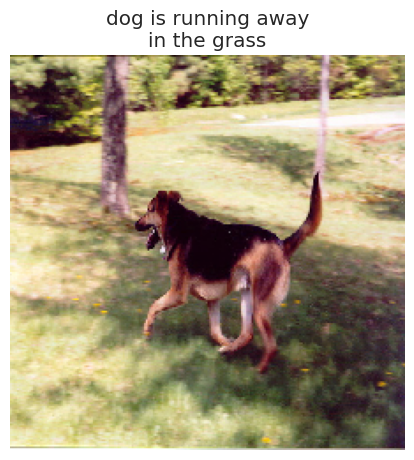

In [ ]:
display_one_images(full_max_sample)

In [ ]:
full_min_sample = Test_set.loc[Test_set["image"] == min_sample["image"]]
full_min_sample

Unnamed: 0.3  Unnamed: 0.2  Unnamed: 0.1  Unnamed: 0  \
555           555           555           555         555   
556           556           556           556         556   
557           557           557           557         557   
558           558           558           558         558   
559           559           559           559         559   

                         image  \
555  3713882697_6dd30c7505.jpg   
556  3713882697_6dd30c7505.jpg   
557  3713882697_6dd30c7505.jpg   
558  3713882697_6dd30c7505.jpg   
559  3713882697_6dd30c7505.jpg   

                                               caption  \
555  fat woman wearing blue tank top and backpack e...   
556  an obese woman holding chili dog in her right ...   
557   woman holding giant hot dog covered with mustard   
558   woman in blue shirt with backpack eating hot dog   
559   woman in blue tank top eats chili cheese hot dog   

                                 new_caption  sim_score  
555  man in red shirt is standing in the air    -0.1468  
556  man in red shirt is standing in the air     0.1140  
557  man in red shirt is standing in the air     0.0834  
558  man in red shirt is standing in the air    -0.0936  
559  man in red shirt is standing in the air    -0.1463

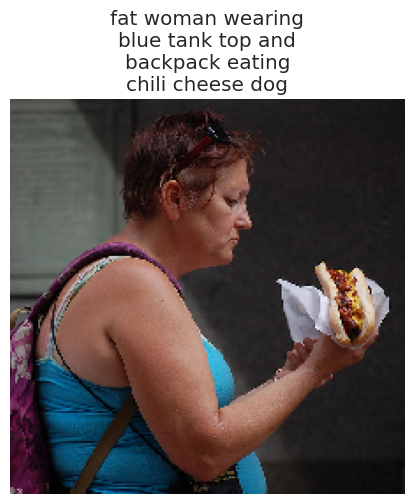

In [ ]:
display_one_images(full_min_sample)